#  Build a Multiple Linear Regression model to predict demand of shared bikes.

## Step#1: Import Libaries and Data Sourcing.

In [1]:
from numpy import * # for scientific computing
from pandas import * # for data analysis
from warnings import filterwarnings
from matplotlib.pyplot import * # for data visualization and graphical plotting
import seaborn as sb_plt

# Libraries to train and test split
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
filterwarnings('ignore')

In [3]:
#Import data set i.e... day.csv, and print first rows of the dataframe
dataframe = read_csv('day.csv')
dataframe.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


## Step#2: Data Understanding

In [4]:
#Inspect the various aspect of the dataframe
print("The shape of the dataset is {} rows and {} columns.".format(dataframe.shape[0],dataframe.shape[1]))

The shape of the dataset is 730 rows and 16 columns.


In [5]:
if (dataframe.duplicated().sum()):
    print("The dataset contains duplicate entries")
else:
    print("The dataset don't contian any duplicate entries")

The dataset don't contian any duplicate entries


In [6]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


### From the dataset info it looks we don't have any NULL values and all the columns have numeric values expect one column dteday(date).

#### From the dataset overview it seems like we can following colmns can be removed:
- instant: It is just an index value.
- dteday: As we have separate column for year and month, this column can be redundant so can be removed.
- causal and registered: As the column cnt is count of total rental bikes including both casual and registered.

In [7]:
list_drop_column = ['instant', 'dteday', 'casual', 'registered']
dataframe.drop(list_drop_column, axis = 'columns', inplace = True)
dataframe.head(20)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600
5,1,0,1,0,4,1,1,8.378268,11.66045,51.8261,6.000868,1606
6,1,0,1,0,5,1,2,8.057402,10.44195,49.8696,11.304642,1510
7,1,0,1,0,6,0,2,6.765000,8.11270,53.5833,17.875868,959
8,1,0,1,0,0,0,1,5.671653,5.80875,43.4167,24.250650,822
9,1,0,1,0,1,1,1,6.184153,7.54440,48.2917,14.958889,1321


In [8]:
dataframe.nunique()

season          4
yr              2
mnth           12
holiday         2
weekday         7
workingday      2
weathersit      3
temp          498
atemp         689
hum           594
windspeed     649
cnt           695
dtype: int64

### From the above it is clearly seems we have the following are categorical columns so, need to update those columns to have meanginful data.

In [9]:
# Create categorical dictonary.
season_dict = {1:'spring', 2:'summer', 3:'fall', 4:'winter'}
yr_dict = {0: '2018', 1:'2019'}
months_dict = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'June',7:'July',8:'Aug',9:'Sept',10:'Oct',11:'Nov',12:'Dec'}
holiday_dict = {0: 'No', 1:'Yes'}
week_day_dict = {0:'Sun',1:'Mon',2:'Tue',3:'Wed',4:'Thurs',5:'Fri',6:'Sat'}
working_day_dict = {0: 'No', 1:'Yes'}
weather_dict = {1:'Clear',2:'Cloudy_or_Mist',3:'Light_Rain_or_Snow',4:'Heavy_Rain_or_Snow'}

In [10]:
dataframe.season.replace(season_dict, inplace = True)
dataframe.yr.replace(yr_dict, inplace = True)
dataframe.mnth.replace(months_dict, inplace = True)
dataframe.holiday.replace(holiday_dict, inplace = True)
dataframe.weekday.replace(week_day_dict, inplace = True)
dataframe.workingday.replace(working_day_dict, inplace = True)
dataframe.weathersit.replace(weather_dict, inplace = True)

In [11]:
#TODO: Delete once done
dataframe.columns.to_series().groupby(dataframe.dtypes).groups

{int64: ['cnt'], float64: ['temp', 'atemp', 'hum', 'windspeed'], object: ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']}

In [12]:
list_categorical_columns = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
list_numerical_columns = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

In [13]:
dataframe[list_categorical_columns] = dataframe[list_categorical_columns].astype('category')

In [14]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      730 non-null    category
 1   yr          730 non-null    category
 2   mnth        730 non-null    category
 3   holiday     730 non-null    category
 4   weekday     730 non-null    category
 5   workingday  730 non-null    category
 6   weathersit  730 non-null    category
 7   temp        730 non-null    float64 
 8   atemp       730 non-null    float64 
 9   hum         730 non-null    float64 
 10  windspeed   730 non-null    float64 
 11  cnt         730 non-null    int64   
dtypes: category(7), float64(4), int64(1)
memory usage: 35.1 KB


In [15]:
dataframe.describe()

,temp,atemp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000
mean,20.319259,23.726322,62.765175,12.763620,4508.006849
std,7.506729,8.150308,14.237589,5.195841,1936.011647
min,2.424346,3.953480,0.000000,1.500244,22.000000
25%,13.811885,16.889713,52.000000,9.041650,3169.750000
50%,20.465826,24.368225,62.625000,12.125325,4548.500000
75%,26.880615,30.445775,72.989575,15.625589,5966.000000
max,35.328347,42.044800,97.250000,34.000021,8714.000000


## Step#3: Data Visualization

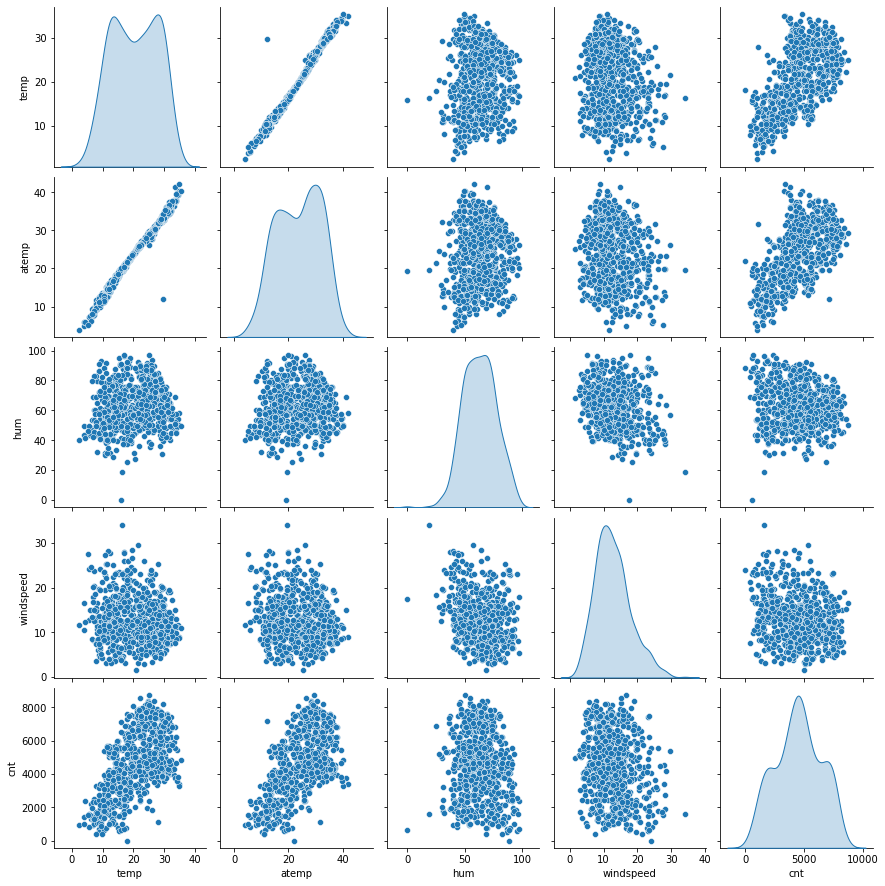

In [16]:
sb_plt.pairplot(dataframe[list_numerical_columns], diag_kind='kde')
show()

### From the above plot is seems we have a liner relationship between the temperature(temp and atemp) and count(cnt).

In [17]:
def univ_count_Plot(axis_col, y_column, x_label, y_label, plot_title, rotation_angle=0, dataframe = dataframe):
    figure(figsize = (15, 6))
    sb_plt.barplot(x = axis_col, y = y_column, hue='yr', data = dataframe, palette = "Set3")
    ylabel(y_label, fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'})
    xlabel(x_label, fontdict={'fontsize': 12, 'fontweight' : 5, 'color' : 'Brown'})
    title(plot_title, fontdict={'fontsize': 20, 'fontweight' : 5, 'color' : 'Green'})
    xticks(rotation = rotation_angle)
    return

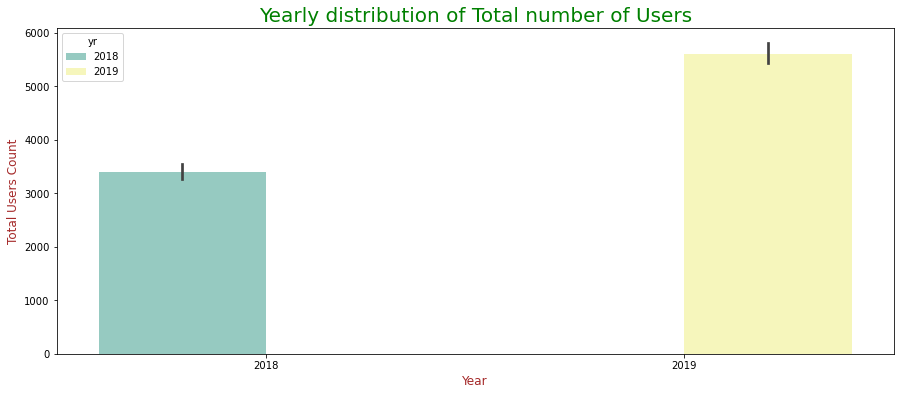

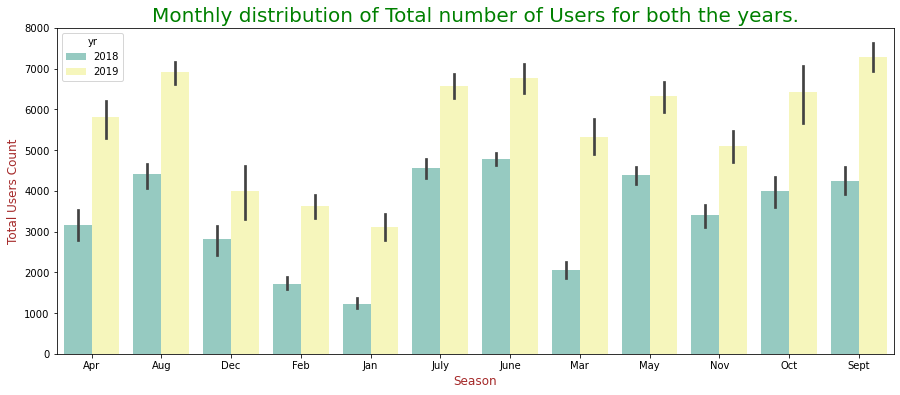

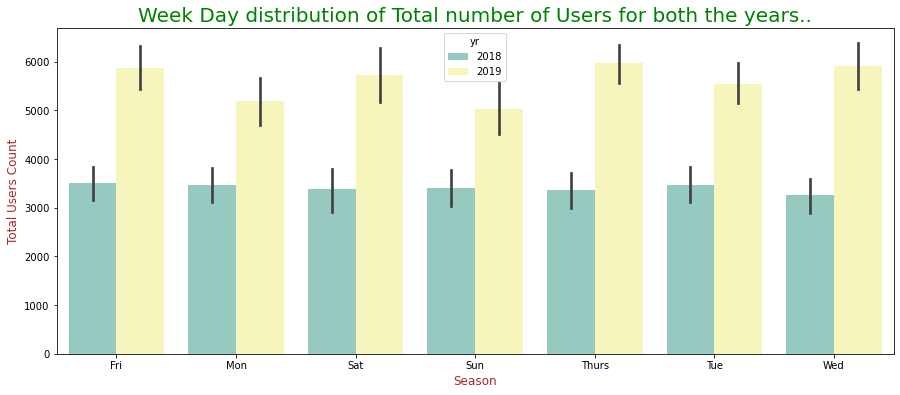

In [18]:
univ_count_Plot('yr', 'cnt', "Year", "Total Users Count", "Yearly distribution of Total number of Users")
univ_count_Plot('mnth', 'cnt', "Season", "Total Users Count", "Monthly distribution of Total number of Users for both the years.")
univ_count_Plot('weekday', 'cnt', "Season", "Total Users Count", "Week Day distribution of Total number of Users for both the years..")

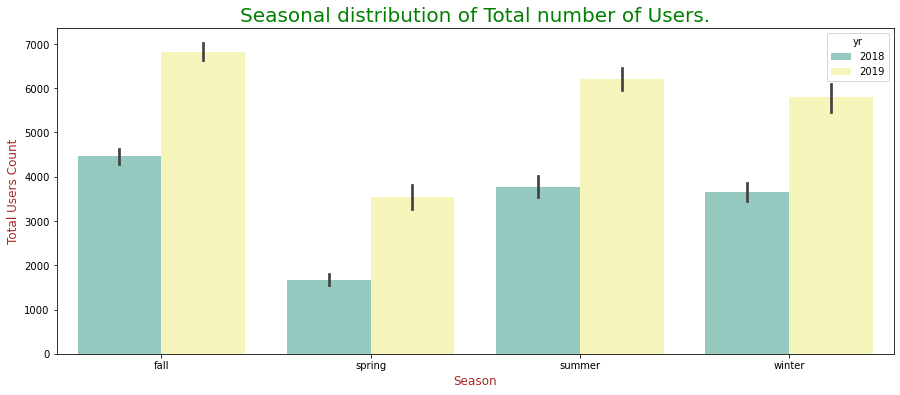

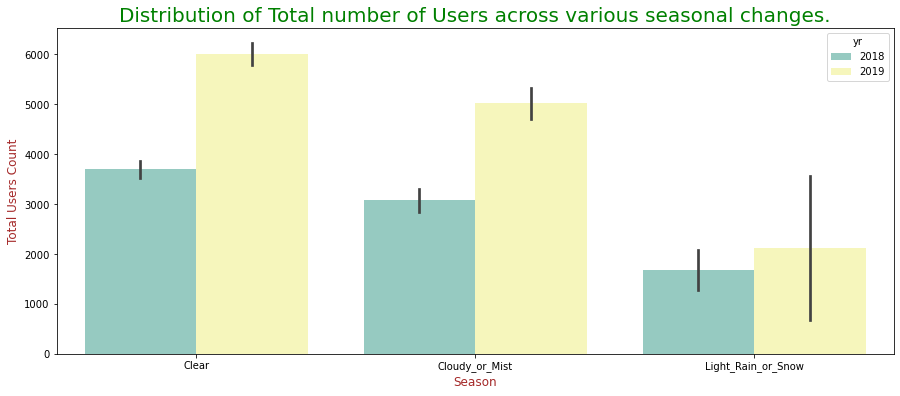

In [19]:
univ_count_Plot('season', 'cnt', "Season", "Total Users Count", "Seasonal distribution of Total number of Users.")
univ_count_Plot('weathersit', 'cnt', "Season", "Total Users Count", "Distribution of Total number of Users across various seasonal changes.")

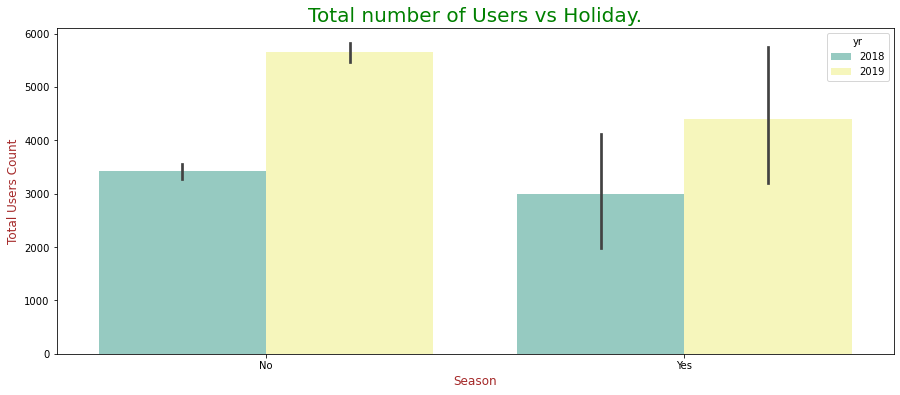

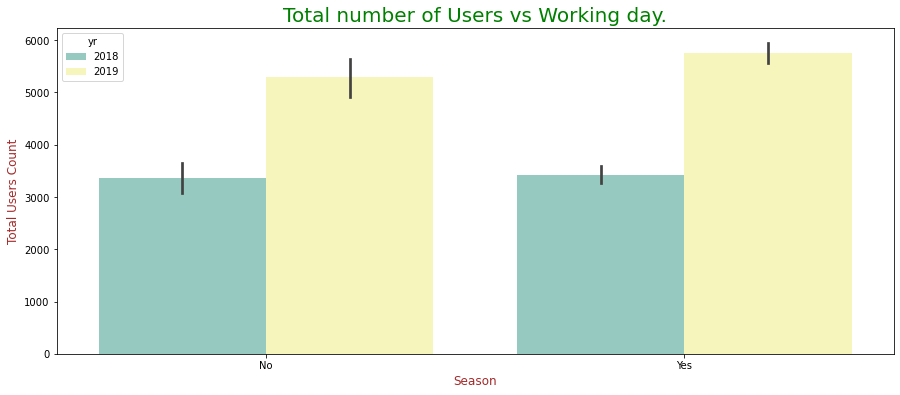

In [20]:
univ_count_Plot('holiday', 'cnt', "Season", "Total Users Count", "Total number of Users vs Holiday.")
univ_count_Plot('workingday', 'cnt', "Season", "Total Users Count", "Total number of Users vs Working day.")

## Step#4: Data Preparation

In [21]:
list_categorical_columns

['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

In [22]:
# 1. Convert the categorical data into dummy variables.
dummy_dataframe = get_dummies(dataframe[list_categorical_columns], drop_first=True)

# concat the dummy dataframe with original.
dataframe = concat([dataframe,dummy_dataframe], axis = 'columns')

dataframe.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,holiday_Yes,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thurs,weekday_Tue,weekday_Wed,workingday_Yes,weathersit_Cloudy_or_Mist,weathersit_Light_Rain_or_Snow
0,spring,2018,Jan,No,Sat,No,Cloudy_or_Mist,14.110847,18.18125,80.5833,...,0,0,1,0,0,0,0,0,1,0
1,spring,2018,Jan,No,Sun,No,Cloudy_or_Mist,14.902598,17.68695,69.6087,...,0,0,0,1,0,0,0,0,1,0
2,spring,2018,Jan,No,Mon,Yes,Clear,8.050924,9.47025,43.7273,...,0,1,0,0,0,0,0,1,0,0
3,spring,2018,Jan,No,Tue,Yes,Clear,8.200000,10.60610,59.0435,...,0,0,0,0,0,1,0,1,0,0
4,spring,2018,Jan,No,Wed,Yes,Clear,9.305237,11.46350,43.6957,...,0,0,0,0,0,0,1,1,0,0


In [23]:
print("The shape of the dataset is {} rows and {} columns.".format(dataframe.shape[0],dataframe.shape[1]))

The shape of the dataset is 730 rows and 37 columns.


In [24]:
# Let's drop the columns whose dummy variables are been created.
dataframe.drop(list_categorical_columns, axis = 'columns', inplace=True)
dataframe.head()

,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,season_winter,yr_2019,mnth_Aug,...,holiday_Yes,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thurs,weekday_Tue,weekday_Wed,workingday_Yes,weathersit_Cloudy_or_Mist,weathersit_Light_Rain_or_Snow
0,14.110847,18.18125,80.5833,10.749882,985,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,14.902598,17.68695,69.6087,16.652113,801,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


#### Splitting the Data into Training and Testing Sets


In [25]:
# We specify this so that the train and test data set always have the same rows, respectively
df_train, df_test = train_test_split(dataframe, train_size = 0.7, test_size = 0.3, random_state = 100)

In [26]:
df_train.describe()

,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,season_winter,yr_2019,mnth_Aug,...,holiday_Yes,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thurs,weekday_Tue,weekday_Wed,workingday_Yes,weathersit_Cloudy_or_Mist,weathersit_Light_Rain_or_Snow
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.00000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,20.102429,23.493909,63.112926,12.831318,4486.382353,0.243137,0.245098,0.24902,0.507843,0.096078,...,0.025490,0.150980,0.154902,0.143137,0.133333,0.131373,0.158824,0.676471,0.343137,0.029412
std,7.431169,8.090038,14.156632,5.291832,1952.158739,0.429398,0.430568,0.43287,0.500429,0.294988,...,0.157763,0.358381,0.362166,0.350557,0.340268,0.338139,0.365870,0.468282,0.475223,0.169124
min,2.424346,3.953480,0.000000,2.834381,22.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.606865,16.603063,52.270825,9.041918,3120.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,20.209597,24.020400,63.437500,12.083182,4530.000000,0.000000,0.000000,0.00000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,26.615847,30.177700,73.250025,15.750879,5973.500000,0.000000,0.000000,0.00000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,35.328347,42.044800,97.041700,34.000021,8714.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
scaler = MinMaxScaler()
df_train[list_numerical_columns] = scaler.fit_transform(df_train[list_numerical_columns])
df_train.head()

,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,season_winter,yr_2019,mnth_Aug,...,holiday_Yes,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thurs,weekday_Tue,weekday_Wed,workingday_Yes,weathersit_Cloudy_or_Mist,weathersit_Light_Rain_or_Snow
653,0.509887,0.501133,0.575354,0.300794,0.864243,0,0,1,1,0,...,0,0,0,0,0,1,0,1,0,0
576,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
426,0.442393,0.438975,0.640189,0.255342,0.465255,1,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
728,0.245101,0.200348,0.498067,0.663106,0.204096,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
482,0.395666,0.391735,0.504508,0.188475,0.482973,0,1,0,1,0,...,0,0,1,0,0,0,0,0,1,0


In [28]:
df_train.describe()

,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,season_winter,yr_2019,mnth_Aug,...,holiday_Yes,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thurs,weekday_Tue,weekday_Wed,workingday_Yes,weathersit_Cloudy_or_Mist,weathersit_Light_Rain_or_Snow
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.00000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.537262,0.512989,0.650369,0.320768,0.513620,0.243137,0.245098,0.24902,0.507843,0.096078,...,0.025490,0.150980,0.154902,0.143137,0.133333,0.131373,0.158824,0.676471,0.343137,0.029412
std,0.225844,0.212385,0.145882,0.169797,0.224593,0.429398,0.430568,0.43287,0.500429,0.294988,...,0.157763,0.358381,0.362166,0.350557,0.340268,0.338139,0.365870,0.468282,0.475223,0.169124
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.540519,0.526811,0.653714,0.296763,0.518638,0.000000,0.000000,0.00000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.735215,0.688457,0.754830,0.414447,0.684710,0.000000,0.000000,0.00000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


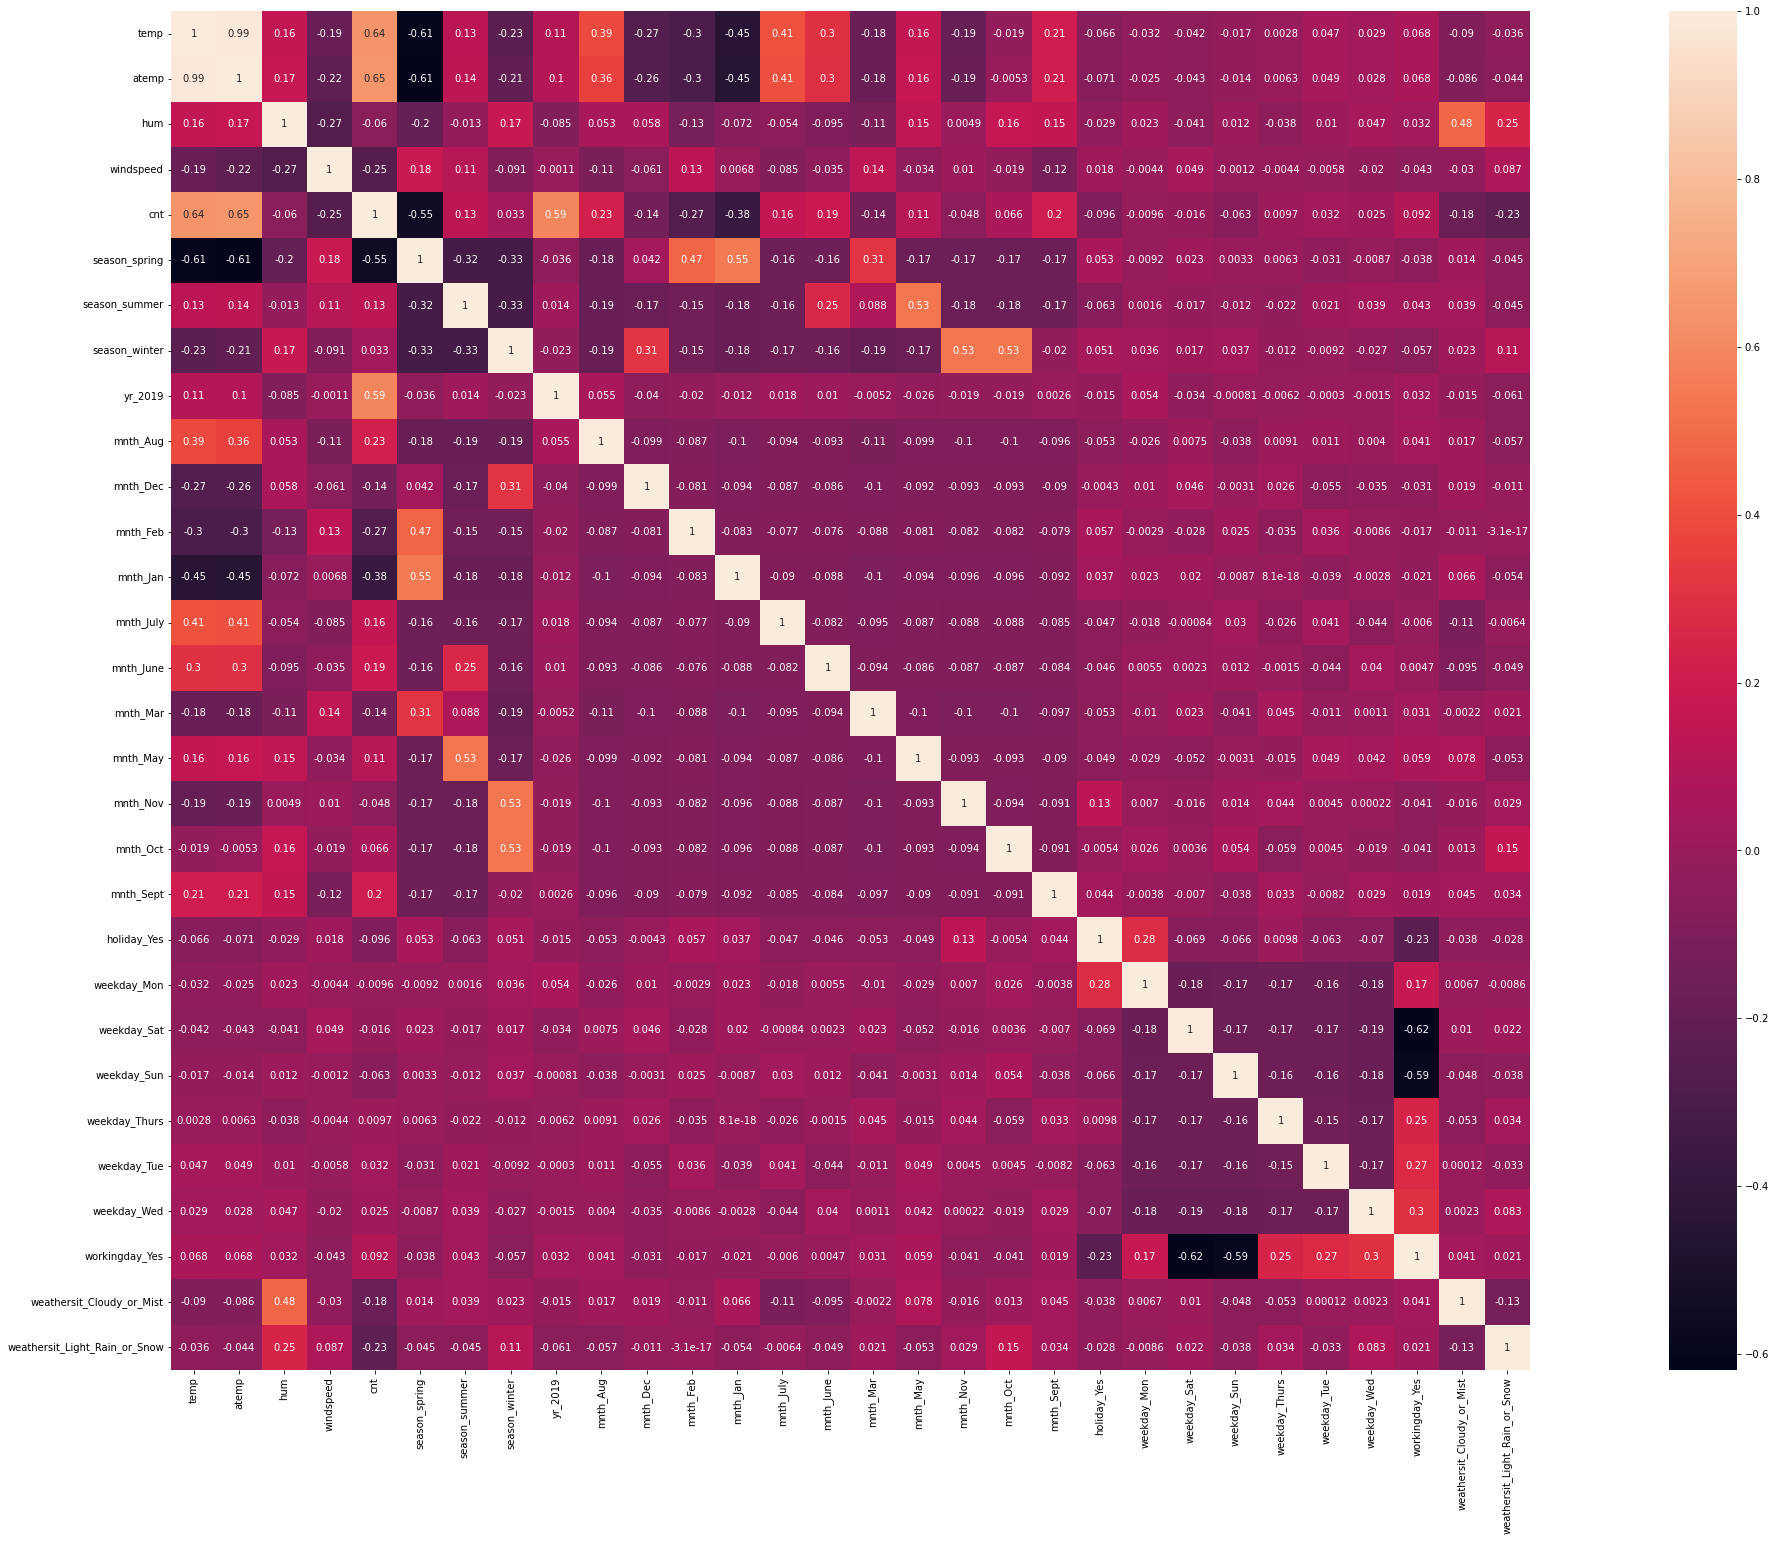

In [29]:
# Now lets plot the co-relation graph.
figure(figsize=(50,25))
# Calculate correlation between each pair of variable
corr_matrix=df_train.corr()

# Draw the heatmap with the mask
sb_plt.heatmap(corr_matrix, annot = True, square=True)
show()

#### Dividing into X and Y sets for the model building

In [30]:
y_train = df_train.pop('cnt')
X_train = df_train
df_train.head()

,temp,atemp,hum,windspeed,season_spring,season_summer,season_winter,yr_2019,mnth_Aug,mnth_Dec,...,holiday_Yes,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thurs,weekday_Tue,weekday_Wed,workingday_Yes,weathersit_Cloudy_or_Mist,weathersit_Light_Rain_or_Snow
653,0.509887,0.501133,0.575354,0.300794,0,0,1,1,0,0,...,0,0,0,0,0,1,0,1,0,0
576,0.815169,0.766351,0.725633,0.264686,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
426,0.442393,0.438975,0.640189,0.255342,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
728,0.245101,0.200348,0.498067,0.663106,1,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
482,0.395666,0.391735,0.504508,0.188475,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0


#### Building our model

In [31]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 15)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [32]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('temp', True, 1),
 ('atemp', False, 5),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_spring', True, 1),
 ('season_summer', True, 1),
 ('season_winter', True, 1),
 ('yr_2019', True, 1),
 ('mnth_Aug', False, 7),
 ('mnth_Dec', False, 3),
 ('mnth_Feb', False, 4),
 ('mnth_Jan', True, 1),
 ('mnth_July', True, 1),
 ('mnth_June', False, 14),
 ('mnth_Mar', False, 15),
 ('mnth_May', False, 6),
 ('mnth_Nov', False, 2),
 ('mnth_Oct', False, 11),
 ('mnth_Sept', True, 1),
 ('holiday_Yes', True, 1),
 ('weekday_Mon', False, 9),
 ('weekday_Sat', True, 1),
 ('weekday_Sun', False, 8),
 ('weekday_Thurs', False, 12),
 ('weekday_Tue', False, 10),
 ('weekday_Wed', False, 13),
 ('workingday_Yes', True, 1),
 ('weathersit_Cloudy_or_Mist', True, 1),
 ('weathersit_Light_Rain_or_Snow', True, 1)]

In [33]:
col = X_train.columns[rfe.support_]
col

Index(['temp', 'hum', 'windspeed', 'season_spring', 'season_summer',
       'season_winter', 'yr_2019', 'mnth_Jan', 'mnth_July', 'mnth_Sept',
       'holiday_Yes', 'weekday_Sat', 'workingday_Yes',
       'weathersit_Cloudy_or_Mist', 'weathersit_Light_Rain_or_Snow'],
      dtype='object')

In [34]:
X_train.columns[~rfe.support_]

Index(['atemp', 'mnth_Aug', 'mnth_Dec', 'mnth_Feb', 'mnth_June', 'mnth_Mar',
       'mnth_May', 'mnth_Nov', 'mnth_Oct', 'weekday_Mon', 'weekday_Sun',
       'weekday_Thurs', 'weekday_Tue', 'weekday_Wed'],
      dtype='object')

#### Building model using statsmodel, for the detailed statistics

In [35]:
def stats_lm(data):
    # Adding a constant variable 
    X_train_sm = sm.add_constant(data)

    # Running the linear model
    lm = sm.OLS(y_train,X_train_sm).fit()
    return lm

In [36]:
def calculate_vif(df):
    vif = DataFrame()
    X = df
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

##### Model#1

In [37]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

print(stats_lm(X_train_rfe).summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     184.6
Date:                Tue, 12 Apr 2022   Prob (F-statistic):          2.31e-191
Time:                        18:16:57   Log-Likelihood:                 519.88
No. Observations:                 510   AIC:                            -1008.
Df Residuals:                     494   BIC:                            -940.0
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [38]:
calculate_vif(X_train_rfe)

,Features,VIF
1,hum,29.40
0,temp,17.77
12,workingday_Yes,5.31
2,windspeed,4.73
3,season_spring,4.53
5,season_winter,3.48
4,season_summer,2.84
13,weathersit_Cloudy_or_Mist,2.29
6,yr_2019,2.09
11,weekday_Sat,1.98


#### From the above we have:
- R-squared: 0.849 and Adj. R-squared:0.844
- All the variable has pvalue < 0.05.
- From VIF calculation we have two variable having VIF > 5:
  - hum: The humidity has highest VIF, so let drop the varible.
  - temp: As per our observation the temperture has good co-relation with the cnt variable so, must keep the this variable for further model.

##### Model#2

In [39]:
# drop varible having high VIF
X_train_new = X_train_rfe.drop(['hum'],axis = 1)

# Create stats model and look for summary
print(stats_lm(X_train_new).summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     190.3
Date:                Tue, 12 Apr 2022   Prob (F-statistic):          7.33e-189
Time:                        18:16:57   Log-Likelihood:                 511.16
No. Observations:                 510   AIC:                            -992.3
Df Residuals:                     495   BIC:                            -928.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [40]:
# Calculate VIF
calculate_vif(X_train_new)

,Features,VIF
0,temp,7.07
11,workingday_Yes,5.24
1,windspeed,4.67
2,season_spring,3.08
3,season_summer,2.33
5,yr_2019,2.08
4,season_winter,1.99
10,weekday_Sat,1.97
6,mnth_Jan,1.62
7,mnth_July,1.59


From the above we have:
- Updated R-squared: 0.849 => 0.843 and Adj. R-squared:0.844 => 0.839
- All the variable has pvalue < 0.05.
- From VIF calculation we have two variable having VIF > 5:
  - temp: Cann't be drop as explained above.
  - workingday_Yes: Next the workingday_Yes has highest VIF, let's drop that and check again

##### Model#3

In [41]:
# drop varible having high VIF
X_train_new = X_train_new.drop(['workingday_Yes'],axis = 1)

# Create stats model and look for summary
print(stats_lm(X_train_new).summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     197.8
Date:                Tue, 12 Apr 2022   Prob (F-statistic):          1.21e-186
Time:                        18:16:57   Log-Likelihood:                 503.12
No. Observations:                 510   AIC:                            -978.2
Df Residuals:                     496   BIC:                            -919.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [42]:
# Calculate VIF
calculate_vif(X_train_new)

,Features,VIF
0,temp,5.16
1,windspeed,4.64
2,season_spring,2.76
3,season_summer,2.23
5,yr_2019,2.07
4,season_winter,1.80
6,mnth_Jan,1.61
7,mnth_July,1.59
11,weathersit_Cloudy_or_Mist,1.56
8,mnth_Sept,1.34


From the above we have:
- There is no significant change in the value of R square and Adjusted R square, so we are on the right track.
- The pvalue of the variable weekday_Sat > 0.05, so need to drop it and update the model.

##### Model#4

In [43]:

# drop varible having high VIF
X_train_new = X_train_new.drop(['weekday_Sat'],axis = 1)

# Create stats model and look for summary
print(stats_lm(X_train_new).summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     213.1
Date:                Tue, 12 Apr 2022   Prob (F-statistic):          3.97e-187
Time:                        18:20:08   Log-Likelihood:                 501.48
No. Observations:                 510   AIC:                            -977.0
Df Residuals:                     497   BIC:                            -921.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [44]:
# Calculate VIF
calculate_vif(X_train_new)

,Features,VIF
0,temp,5.13
1,windspeed,4.61
2,season_spring,2.75
3,season_summer,2.22
5,yr_2019,2.07
4,season_winter,1.79
6,mnth_Jan,1.61
7,mnth_July,1.59
10,weathersit_Cloudy_or_Mist,1.56
8,mnth_Sept,1.34


From the above we have:
- There is no significant change in the value of R square and Adjusted R square, so we are on the right track.
- The pvalue of the variable mnth_Jan > 0.05, so need to drop it and update the model.

##### Model#5

In [45]:
# drop varible having high VIF
X_train_new = X_train_new.drop(['mnth_Jan'],axis = 1)

# Create stats model and look for summary
print(stats_lm(X_train_new).summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     230.4
Date:                Tue, 12 Apr 2022   Prob (F-statistic):          2.40e-187
Time:                        18:21:30   Log-Likelihood:                 499.17
No. Observations:                 510   AIC:                            -974.3
Df Residuals:                     498   BIC:                            -923.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [46]:
# Calculate VIF
calculate_vif(X_train_new)

,Features,VIF
0,temp,5.09
1,windspeed,4.60
3,season_summer,2.21
2,season_spring,2.08
5,yr_2019,2.07
4,season_winter,1.79
6,mnth_July,1.58
9,weathersit_Cloudy_or_Mist,1.55
7,mnth_Sept,1.34
10,weathersit_Light_Rain_or_Snow,1.08


From the above we have:
- There is no significant change in the value of R square and Adjusted R square, so we are on the right track.
- The pvalue of the variable mnth_July ~ 0.05, so let's drop it and update the model.

##### Model#6

In [47]:
# drop varible having high VIF
X_train_new = X_train_new.drop(['mnth_July'],axis = 1)

# Create stats model and look for summary
print(stats_lm(X_train_new).summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     249.2
Date:                Tue, 12 Apr 2022   Prob (F-statistic):          7.36e-187
Time:                        18:23:40   Log-Likelihood:                 495.16
No. Observations:                 510   AIC:                            -968.3
Df Residuals:                     499   BIC:                            -921.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [48]:
# Calculate VIF
calculate_vif(X_train_new)

,Features,VIF
1,windspeed,4.59
0,temp,3.84
5,yr_2019,2.07
2,season_spring,1.99
3,season_summer,1.89
4,season_winter,1.63
8,weathersit_Cloudy_or_Mist,1.54
6,mnth_Sept,1.23
9,weathersit_Light_Rain_or_Snow,1.08
7,holiday_Yes,1.04


From the above we have:
- There is no significant change in the value of R square and Adjusted R square, so we are on the right track.
- The pvalue of the variable season_spring > 0.05, so need to drop it and update the model.

##### Model#7

In [49]:
# drop varible having high VIF
X_train_new = X_train_new.drop(['season_spring'],axis = 1)

# Create stats model and look for summary
print(stats_lm(X_train_new).summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     272.9
Date:                Tue, 12 Apr 2022   Prob (F-statistic):          1.37e-186
Time:                        18:25:36   Log-Likelihood:                 491.62
No. Observations:                 510   AIC:                            -963.2
Df Residuals:                     500   BIC:                            -920.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [50]:
# Calculate VIF
calculate_vif(X_train_new)

,Features,VIF
0,temp,3.68
1,windspeed,3.05
4,yr_2019,2.00
2,season_summer,1.56
7,weathersit_Cloudy_or_Mist,1.48
3,season_winter,1.38
5,mnth_Sept,1.20
8,weathersit_Light_Rain_or_Snow,1.08
6,holiday_Yes,1.03


#### Residual Analysis of the train data

In [61]:
lm_final = stats_lm(X_train_new)
var_final = list(lm_final.params.index)
var_final.remove('const')

print(round(lm_final.params,3))

const                            0.126
temp                             0.548
windspeed                       -0.153
season_summer                    0.087
season_winter                    0.131
yr_2019                          0.233
mnth_Sept                        0.101
holiday_Yes                     -0.099
weathersit_Cloudy_or_Mist       -0.080
weathersit_Light_Rain_or_Snow   -0.284
dtype: float64


In [62]:
# Select final variables from the test dataset
X_train_res = X_train[var_final]

#Add constant
X_train_res = sm.add_constant(X_train_res)

# predict train set
y_train_pred = lm_final.predict(X_train_res)

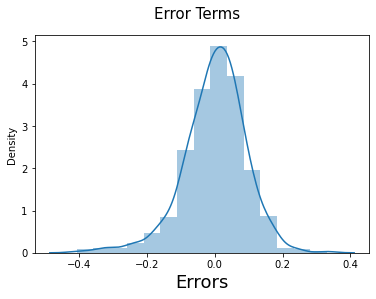

In [72]:
# Plot the histogram of the error terms
# distrubition plot for residue
res = y_train - y_train_pred
fig = figure()
sb_plt.distplot(res, bins = 15)
fig.suptitle('Error Terms', fontsize = 15)                  # Plot heading 
xlabel('Errors', fontsize = 18)                         # X-label
show()

#### The error terms are also normally distributed (which is infact, one of the major assumptions of linear regression)

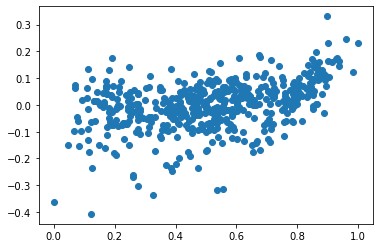

In [80]:
# Error terms train set
scatter(y_train,res)
show()

In [81]:
df_test[list_numerical_columns] = scaler.transform(df_test[list_numerical_columns])

In [82]:
#Dividing into X_test and y_test
y_test = df_test.pop('cnt')
X_test = df_test

In [83]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_new.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [84]:
# Making predictions
y_pred = lm_final.predict(X_test_new)

In [88]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

r_squared = r2_score(y_test, y_pred)
r_squared

0.7938290016640651

Text(0, 0.5, 'y_pred')

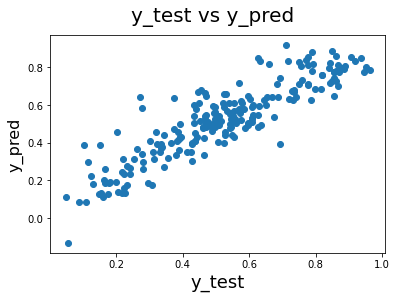

In [87]:
# Plotting y_test and y_pred to understand the spread.
fig = figure()
scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
xlabel('y_test', fontsize=18)                          # X-label
ylabel('y_pred', fontsize=16)                          # Y-label